In [1]:
# Import libraries
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm

from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import QuantileTransformer
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.base import TransformerMixin, BaseEstimator
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import mean_squared_error, mean_absolute_error
pd.options.mode.chained_assignment = None

from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.linear_model import Ridge, RidgeCV, LassoCV
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.svm import SVR
import pickle

# Set matplotlib options
%matplotlib inline
color = '#1F77B4'    # Color is used in barcharts
fontsize=16     # Font size of a  figure title

pd.set_option('display.max_columns', 100)
pd.set_option('display.max_rows', 200)


test_data = '2. Prepared Data/public_cars.csv'
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(test_data)
df_pred = pd.read_csv(prediction_data)

print("The train dataset rows: {} , columns: {} ".format(df.shape[0],df.shape[1]))
print(df.shape)
print("The test dataset rows: {} , columns: {} ".format(df_pred.shape[0],df_pred.shape[1]))
print(df_pred.shape)

The train dataset rows: 14032 , columns: 26 
(14032, 26)
The test dataset rows: 7707 , columns: 25 
(7707, 25)


In [2]:
print('Dataset: {}'.format(df.shape))
# Find missing values 
print(f'Missing values: {df.isnull().sum()}')

# Missing price
isnull_filter = df['price_usd'].isnull()
#Electric cars
isnull_filter = df['engine_capacity'].isnull()

# Filter rows with missing values
isnull_filter = (df['price_usd'].isnull() | df['engine_capacity'].isnull()) 
# Drop the row with missing price and electric cars
missing_price = len(df[isnull_filter].index)
print('\nDropped rows: {}'.format(missing_price))

# Save the rows with missing data to csv file
fl = "4. Analysis/used_car_prices_missing_data.csv"
missing_data= df[isnull_filter]
missing_data.to_csv(fl, index=False)

df.drop(df[isnull_filter].index, inplace=True)
df = df.reset_index(drop=True)
print('Dataset: {}'.format(df.shape))

# Find missing values 
print('\nMissing values: {}'.format(df.isnull().sum().sum()))

Dataset: (14032, 26)
Missing values: manufacturer_name    0
model_name           0
transmission         0
color                0
odometer_value       0
year_produced        0
engine_fuel          0
engine_has_gas       0
engine_type          0
engine_capacity      5
body_type            0
has_warranty         0
state                0
drivetrain           1
feature_0            1
feature_1            1
feature_2            1
feature_3            1
feature_4            1
feature_5            1
feature_6            1
feature_7            1
feature_8            1
feature_9            1
duration_listed      1
price_usd            1
dtype: int64

Dropped rows: 6
Dataset: (14026, 26)

Missing values: 0


In [3]:
# Round car price to hundreds
df['price_round']=df['price_usd'].apply(lambda x: round(x, -2))


###################################### OUTLIERS  ################################################

# Numerical features
mask1=(df['odometer_value'] > 250000) & (df['price_usd']>30000)
mask2=(df['year_produced'] < 1955) 
mask3=(df['year_produced'] < 1970) & (df['price_usd']>10000)
mask4=(df['engine_capacity'] < 0.8)
#mask5=(df['odometer_value/year']>95000)
mask6=(df['duration_listed']>2100)
mask7=(df['price_usd']<100) | (df['price_usd']>48000)

# Combine all filters
outliers = df[mask1|mask2|mask3|mask4|mask6|mask7] # mask5|
#outliers

# Save the rows with extreme outliers to csv file
fl = "4. Analysis/used_car_prices_EDA_extreme_outliers.csv"
outliers.to_csv(fl, index=False)
       
print("Dataset: {}".format(df.shape))
df.drop(outliers.index, inplace=True )
df.reset_index(drop=True)
print('Drop {} outliers'.format(len(outliers)))
print("Dataset: {}".format(df.shape)) 

# Copy the data set
df_origin = df.copy()

Dataset: (14026, 27)
Drop 20 outliers
Dataset: (14006, 27)


### Feature engineering

In [4]:
# Create a class to perform feature engineering 
class FeatureEngineering(BaseEstimator, TransformerMixin):
       
    def fit(self, X, y=None):
        return self  
    
    def transform(self, X, y=None):
        df = X
        # Convert boolean values to integer
        df['engine_has_gas']=df['engine_has_gas'].astype(int)
        df['has_warranty']=df['has_warranty'].astype(int)

        # Create a feature that represents mileage per year
        df['odometer_value']=df['odometer_value'].apply(lambda x: round(x, -2))
        df['odometer_value/year'] = round(df['odometer_value']/(2020 - df['year_produced']),-2)
        # Create a feature how old is a car
        df['year'] = 2020 - df['year_produced']

        ################################# Reduce a number of categories  ######################################
    
        # Combine manufacturer and model names 
        df['name'] = df['manufacturer_name'].apply(lambda x: x.strip()) + ' ' + df['model_name'].apply(lambda x: x.strip())

        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 10
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['manufacturer_name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['manufacturer_name'] < car_total].index
        # create a new category'other' for rare car model names
        df['manufacturer_name'] = df['manufacturer_name'].apply(lambda x: 'other' if x in car_models_list else x)
        
        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 10
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['model_name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['model_name'] < car_total].index
        # create a new category'other' for rare car model names
        df['model_name'] = df['model_name'].apply(lambda x: 'other' if x in car_models_list else x)
        """
        # Reduce the number of car model names
        # Set a limit of rare car occurrence
        car_total = 20
        # Count a number of car names and convert the result to a dataframe
        car_models = pd.DataFrame(df['name'].value_counts())
        # Get a list of rare car names
        car_models_list = car_models[car_models['name'] < car_total].index
        # create a new category'other' for rare car model names
        df['name'] = df['name'].apply(lambda x: 'other' if x in car_models_list else x)
        
        # Reduce the number of colors
        df['color']=df['color'].replace({'violet':'other','yellow':'other','orange':'other', 'brown':'other'})

        # Reduce the number of body tipes 
        df['body_type']=df['body_type'].replace({'pickup':'other','cabriolet':'other','limousine':'other'})

        # Add 'hybrid-diesel' to 'diesel' category
        df['engine_fuel']=df['engine_fuel'].replace({'hybrid-diesel':'diesel'})
        """
        ################################# End Reduce a number of categories  ######################################
        
        
        # Create a list of unnamed features
        features_list = ['feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 'feature_6', 'feature_7', 'feature_8', 'feature_9']
        
        for feature in features_list:
            df[feature]=df[feature].astype(int)
        # Count a total number of unnamed features for a car
        df['other_features']=df[features_list].sum(axis=1).astype(int)
        
        global feats
        feats = ['name', 'odometer_value/year', 'year', 'other_features'] 
        
        X=df
        return X

# Create a pipeline for feature engineering
feature_engineering = Pipeline(steps=
                               [('features', FeatureEngineering())
                               ])


### Preprocessing pipeline

In [5]:
# Numeric data types
numerics = ['int16', 'int32', 'int64', 'float16', 'float32', 'float64']

# Applies Power Transformer using Yeo-Johnson transformation to numeric columns 
numeric_power = ['odometer_value',  'odometer_value/year', 'duration_listed']

numeric_power_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('power', PowerTransformer(method='yeo-johnson')),
                                     ('scaler', StandardScaler())
                                    ])

# Applies Quantile Transformer to numeric columns 
numeric_quantile = ['engine_capacity', 'year', 'other_features']

numeric_quantile_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value=0)),
                                     ('quantile', QuantileTransformer(output_distribution='normal')),  
                                     ('scaler', StandardScaler())
                                    ])

# Print numeric features
numeric_features = numeric_power + numeric_quantile
print('Numeric features: {}'.format(numeric_features))

# Print categorical features
#categorical_features = X.select_dtypes([np.object,np.bool]).columns.tolist()
categorical_features = ['state', 'has_warranty',
                       'manufacturer_name', 'model_name', 'drivetrain', 'transmission']
                        #'feature_0','feature_1', 'feature_2', 'feature_3', 'feature_4', 'feature_5', 
                        #'feature_6', 'feature_7', 'feature_8', 'feature_9']
print('Categorical features: {}'.format(categorical_features))

# Transform categorical columns using OneHotEncoder
categorical_transformer = Pipeline(steps=
                                    [('imputer', SimpleImputer(strategy='constant', fill_value='missing')),
                                     ('onehot', OneHotEncoder(handle_unknown='ignore'))
                                    ])

# Create ColumnTransformer to perform transformations for different types of features
column_transformer = ColumnTransformer(transformers=
                                     [('num_power', numeric_power_transformer, numeric_power),
                                      ('num_qt', numeric_quantile_transformer, numeric_quantile),
                                      ('cat', categorical_transformer, categorical_features)
                                     ])

# Preprocessing pipeline
preprocessing = Pipeline(steps=
                [('feature_engineering', feature_engineering),
                 ('column_transformer', column_transformer),
            
                ])  

Numeric features: ['odometer_value', 'odometer_value/year', 'duration_listed', 'engine_capacity', 'year', 'other_features']
Categorical features: ['state', 'has_warranty', 'manufacturer_name', 'model_name', 'drivetrain', 'transmission']


#### Transformation of the target variable

In [6]:
# Drop a column
data = df.drop('price_usd',axis=1).copy()
print('Dataset: {}'.format(data.shape))

# Set target and features variables
target='price_round'

X = data.drop(target, axis=1)
y = data[target]

# Split data into random train and test subsets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)

############################### Transform the target variable #####################################
power_tr = PowerTransformer(method='yeo-johnson')

# Reshape into 2D array
y_train=np.array(y_train).reshape(-1, 1)
y_test=np.array(y_test).reshape(-1, 1)

power_tr.fit(y_train)

y_train = power_tr.transform(y_train)
y_test = power_tr.transform(y_test)

Dataset: (14006, 26)


### Model selection

LinearRegression()
Score: 0.8684062695261114
MSE: -0.16431855761428724


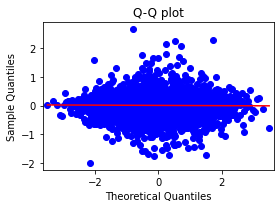

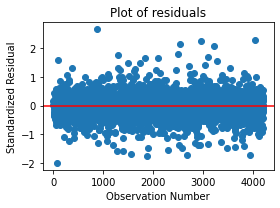

In [7]:
# Create an instance of a model
model = LinearRegression()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessing', preprocessing),
                 ('model', model)
                ])

pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Store the 5 scores in an object and take the mean
mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error').mean()
print('MSE: {}'.format(mse))

score_1 = score
mse_1 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

LassoCV()
Score: 0.8621400904091366
MSE: -0.16030489630606898


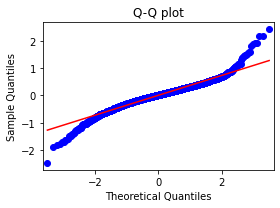

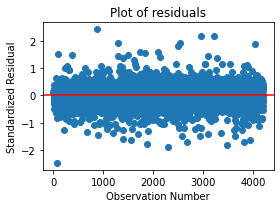

In [8]:
######################################### LassoCV model ######################################
# Create an instance of a model
model = LassoCV()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessing', preprocessing),
                 ('model', model)
                ])  


# Reshape into 1D array
y_train=y_train.ravel()
y_test=y_test.ravel()

pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_2 = score
mse_2 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

RidgeCV(alphas=array([ 0.1,  1. , 10. ]))
Score: 0.8702036089282769
MSE: -0.162579538309451


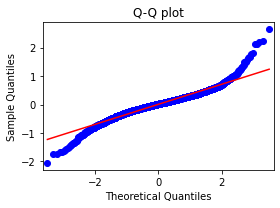

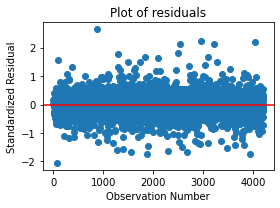

In [9]:
######################################### RidgeCV model ######################################
# Create an instance of a model
model = RidgeCV()  
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessing', preprocessing),
                 ('model', model)
                ])  

# Reshape into 1D array
y_train=y_train.ravel()
y_test=y_test.ravel()

pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_3 = score
mse_3 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

GradientBoostingRegressor()
Score: 0.8823879997316535
MSE: -0.12668710004579378


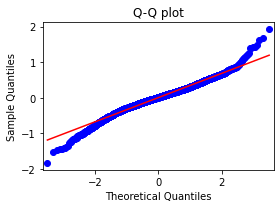

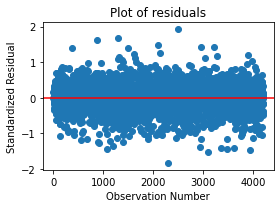

In [10]:
######################################### Gradient Boosting Regressor model ######################################
# Create an instance of a model
model = GradientBoostingRegressor()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessing', preprocessing),
                 ('model', model)
                ])  

# Reshape into 1D array
y_train=y_train.ravel()
y_test=y_test.ravel()

pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_4 = score
mse_4 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

SVR()
Score: 0.90770775006516
MSE: -0.11739145277043239


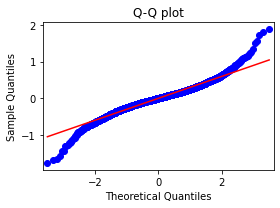

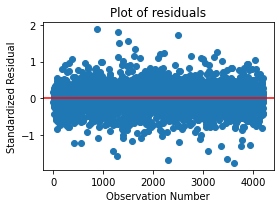

In [11]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=
                [('preprocessing', preprocessing),
                 ('model', model)
                ])  

# Reshape into 1D array
y_train=y_train.ravel()
y_test=y_test.ravel()

pipe.fit(X_train, y_train)

score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

mse = cross_val_score(pipe, X_test, y_test, cv=5, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

score_5 = score
mse_5 = mse

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

In [12]:
# Compare results in one table
model_names = ['Linear Regression','LassoCV','RidgeCV','Gradient Boosting Regressor', 'SVR']
score = [score_1, score_2, score_3, score_4, score_5]
mse = [mse_1, mse_2, mse_3, mse_4, mse_5]

table = {'Score': score, 'MSE': mse}

table_df = pd.DataFrame(data=table, index=model_names)
table_df

,Score,MSE
Linear Regression,0.868406,-0.164319
LassoCV,0.862140,-0.160305
RidgeCV,0.870204,-0.162580
Gradient Boosting Regressor,0.882388,-0.126687
SVR,0.907708,-0.117391


### Model tuning

In [13]:
######################################### SVR model ######################################
# Create an instance of a model
model = SVR()
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessing', preprocessing),
                       ('model', model)])  

y_train = y_train.ravel()


################################### GridS earch ###########################################
param_grid = {'model__C': [0.1, 0.5, 1, 2, 5],
              'model__kernel':['linear', 'poly', 'rbf']
             }
search = GridSearchCV(pipe, param_grid, cv=5).fit(X_train, y_train) 

print('The best parameters: {}'.format(search.best_params_))
print('The best score: {}'.format(search.best_score_))

SVR()
The best parameters: {'model__C': 1, 'model__kernel': 'rbf'}
The best score: 0.8901883088363682


### Final model

SVR(C=1)
Score: 0.90770775006516
MSE: -0.12512736179870965


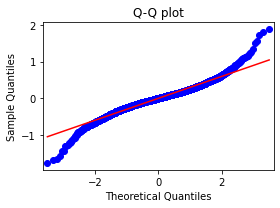

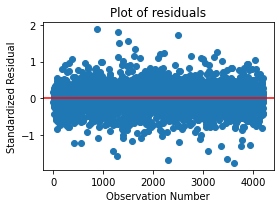

In [14]:
######################################### SVR model ######################################
# Create an instance of a model
model = search.best_estimator_['model']
print(model)

# Define preprocessing pipeline
pipe = Pipeline(steps=[('preprocessing', preprocessing),
                       ('model', model)])  

y_train = y_train.reshape(-1)
y_test = y_test.reshape(-1)

pipe.fit(X_train, y_train)
score = pipe.score(X_test, y_test)
print('Score: {}'.format(score))

# Get prediction
y_predict_train = pipe.predict(X_train)
y_predict_test = pipe.predict(X_test)

mse = cross_val_score(pipe, X_test, y_test, cv=10, scoring ='neg_mean_squared_error' ).mean()
print('MSE: {}'.format(mse))

# Find out residuals
resud=y_test-y_predict_test
# Convert array to DataFrame
stdresud=pd.DataFrame(resud)

#Q-Q plot for normality
fig, ax = plt.subplots(figsize=(4,3))
sm.qqplot(resud, line='r',ax=ax)
ax.set_title('Q-Q plot')
plt.tight_layout()

# Plot of residuals
fig, ax = plt.subplots(figsize=(4,3))
plt.plot(stdresud, 'o', ls='None')
l = plt.axhline(y=0, color='r')
ax.set_ylabel('Standardized Residual')
ax.set_xlabel('Observation Number')
ax.set_title('Plot of residuals')
plt.tight_layout()

The qqplot for the regression model shows that the residuals generally follow a straight line, but deviate at the lower and higher quantiles. This indicates that our residuals did not follow perfect normal distribution. There might be other explanatory variables that we might consider including in our model, that could improve estimation.

In [15]:
y_predict_test_price = power_tr.inverse_transform(y_predict_test.reshape(-1,1))
y_predict_test_price_round = np.round(y_predict_test_price,-2)
results = pd.DataFrame( {'Actual transformed':y_test.reshape(-1), 'Predicted':y_predict_test.reshape(-1),
                         'Predicted inverse transformed':y_predict_test_price.reshape(-1), 
                         'Predicted inverse transformed rounded':y_predict_test_price_round.reshape(-1)},
                       index=X_test.index)

results = results.join(df_origin['price_round'], how ='left')
results.rename(columns={'price_round':'Actual'}, inplace=True)

print('Car Prices')
results.head(10)

Car Prices


,Actual transformed,Predicted,Predicted inverse transformed,Predicted inverse transformed rounded,Actual
468,0.288630,0.378003,6630.386611,6600.0,6100.0
450,-1.105486,-1.277121,1136.911108,1100.0,1400.0
1756,-0.425141,-0.282065,3481.842411,3500.0,3000.0
7937,-1.380065,-1.545943,808.503652,800.0,1000.0
2985,-1.167258,-0.753223,2101.880759,2100.0,1300.0
1093,0.716066,0.782461,9540.051639,9500.0,9000.0
12990,1.200234,1.061147,12112.905475,12100.0,13600.0
5069,-0.559382,-0.675821,2290.199624,2300.0,2600.0
7925,1.191292,1.030755,11806.805674,11800.0,13500.0
6817,1.191292,0.922344,10767.175520,10800.0,13500.0


In [16]:
mse = mean_squared_error(results['Actual'], results['Predicted inverse transformed'])
print('MSE: {}'.format(mse))

MSE: 3899214.236315637


In [17]:
# Save the pipeline for model
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'wb') as f:
    pickle.dump(pipe, f)

print('The file {} is saved.'.format(model_path))

# Save the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'wb') as f:
    pickle.dump(power_tr, f)
print('The file {} is saved.'.format(transformer_path))

The file 5. Insights/Models/used_car_prices_model.pickle is saved.
The file 5. Insights/Models/used_car_prices_target_transformation.pickle is saved.


## Ptrediction 

In [18]:
# Load the data
prediction_data = '2. Prepared Data/pred_cars.csv'
df = pd.read_csv(prediction_data)

# Load a model from a file
model_path = '5. Insights/Models/used_car_prices_model.pickle'
with open(model_path, 'rb') as f:
    regression_model_loaded = pickle.load(f)
print('Regression model {} is loaded.'.format(regression_model_loaded))

# Load the PorewTransformer object for the inverse target transformation
transformer_path = '5. Insights/Models/used_car_prices_target_transformation.pickle'
with open(transformer_path, 'rb') as f:
    transformer_loaded = pickle.load(f)
print('Transformer {} is loaded.'.format(transformer_loaded))

Regression model Pipeline(steps=[('preprocessing',
                 Pipeline(steps=[('feature_engineering',
                                  Pipeline(steps=[('features',
                                                   FeatureEngineering())])),
                                 ('column_transformer',
                                  ColumnTransformer(transformers=[('num_power',
                                                                   Pipeline(steps=[('imputer',
                                                                                    SimpleImputer(fill_value=0,
                                                                                                  strategy='constant')),
                                                                                   ('power',
                                                                                    PowerTransformer()),
                                                                                   ('scale

In [19]:
df.head()

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,False,gasoline,1.6,coupe,False,owned,front,False,True,False,False,False,False,False,True,False,True,114
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,False,gasoline,1.4,hatchback,False,owned,front,False,False,False,False,False,False,False,False,False,True,67
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,False,gasoline,2.0,minivan,False,owned,front,True,False,False,False,False,False,False,False,False,False,50
3,Volvo,XC60,mechanical,white,230000,2009,diesel,False,diesel,2.4,universal,False,owned,front,False,True,True,True,False,True,True,True,True,True,79
4,Mazda,3,mechanical,silver,206000,2007,gasoline,False,gasoline,1.6,sedan,False,owned,front,False,True,False,True,False,True,False,False,False,False,74


In [20]:
# Create new features
#df=feature_engineering_loaded.fit_transform(df)

# Make prediction using the pipeline
#prediction = regression_model_loaded.predict(df[features])
prediction = regression_model_loaded.predict(df)
prediction

array([-1.02799   , -0.79521021,  0.08000923, ..., -0.36727645,
        1.03848355, -0.65935384])

In [21]:
# Transform predicted price to get the rounded car price in dollars
y_predict_price = transformer_loaded.inverse_transform(prediction.reshape(-1,1))
# Round car price to hundred
y_predict_price_round = np.round(y_predict_price,-2)
# Create a dataframe with results
results = pd.DataFrame( {'Predicted':y_predict_price.reshape(-1),
                         'Predicted rounded':y_predict_price_round.reshape(-1)},
                          index=df.index)

# Form a dataframe with car information and predicted prices
prediction_results = df.join(results)

# Save car information and predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_prediction_data_predicted_price.csv"
prediction_results.to_csv(fl, index=False)

# Save predicted prices to csv file
fl = "5. Insights/Prediction/used_car_prices_predicted_price.csv"
results.to_csv(fl, index=False)

In [22]:
# Car information and predicted prices
prediction_results

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,odometer_value/year,year,name,other_features,Predicted,Predicted rounded
0,Renault,Megane,mechanical,blue,360000,1997,gasoline,0,gasoline,1.6,coupe,0,owned,front,0,1,0,0,0,0,0,1,0,1,114,15700.0,23,Renault Megane,3,1534.490386,1500.0
1,Peugeot,206,mechanical,silver,267000,1999,gasoline,0,gasoline,1.4,hatchback,0,owned,front,0,0,0,0,0,0,0,0,0,1,67,12700.0,21,Peugeot 206,1,2005.274949,2000.0
2,Volkswagen,Sharan,mechanical,blue,172000,2000,gasoline,0,gasoline,2.0,minivan,0,owned,front,1,0,0,0,0,0,0,0,0,0,50,8600.0,20,Volkswagen Sharan,1,4998.671568,5000.0
3,Volvo,XC60,mechanical,white,230000,2009,diesel,0,diesel,2.4,universal,0,owned,front,0,1,1,1,0,1,1,1,1,1,79,20900.0,11,Volvo XC60,8,12376.978653,12400.0
4,Mazda,3,mechanical,silver,206000,2007,gasoline,0,gasoline,1.6,sedan,0,owned,front,0,1,0,1,0,1,0,0,0,0,74,15800.0,13,Mazda 3,3,5262.478646,5300.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7702,Chrysler,other,automatic,blue,347600,2001,gasoline,0,gasoline,2.4,sedan,0,owned,front,1,0,0,0,0,0,0,0,0,0,81,18300.0,19,Chrysler Sebring,1,2921.280507,2900.0
7703,Geely,other,automatic,black,9700,2018,gasoline,0,gasoline,2.0,suv,0,owned,front,0,1,0,1,0,1,0,1,1,1,84,4800.0,2,Geely Emgrand 7,6,15893.337885,15900.0
7704,Chrysler,other,automatic,red,111100,2001,gasoline,0,gasoline,2.4,sedan,0,owned,front,1,0,0,0,0,0,0,0,0,0,1,5800.0,19,Chrysler Sebring,1,3187.657600,3200.0
7705,Ford,other,mechanical,white,109000,2016,diesel,0,diesel,1.5,suv,0,owned,front,0,0,0,1,0,0,1,1,1,1,2,27200.0,4,Ford EcoSport,5,11884.021409,11900.0


In [23]:
# Predicted car prices
results

,Predicted,Predicted rounded
0,1534.490386,1500.0
1,2005.274949,2000.0
2,4998.671568,5000.0
3,12376.978653,12400.0
4,5262.478646,5300.0
...,...,...
7702,2921.280507,2900.0
7703,15893.337885,15900.0
7704,3187.657600,3200.0
7705,11884.021409,11900.0


In [24]:
test_car={}
test_car["manufacturer_name"] = "Dodge"
test_car["model_name"]= "Grand Caravan"
test_car["transmission"]= "mechanical"
test_car["color"]= "grey"
test_car["odometer_value"]= 257495
test_car["year_produced"]= 2005
test_car["engine_fuel"]= "gasoline"
test_car["engine_has_gas"]= False
test_car["engine_type"]= "gasoline"
test_car["engine_capacity"]= 3.3
test_car["body_type"]= "minivan"
test_car["has_warranty"]= False
test_car["state"]= "owned"
test_car["drivetrain"]= "front"
test_car["feature_0"]= False
test_car["feature_1"]= False
test_car["feature_2"]= False
test_car["feature_3"]= True
test_car["feature_4"]= False
test_car["feature_5"]= False
test_car["feature_6"]= False
test_car["feature_7"]= True
test_car["feature_8"]= False
test_car["feature_9"]= False
test_car["duration_listed"]= 25

cols_str='manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed'
columns=cols_str.split(',')
df=pd.DataFrame(test_car, index=[0])
df

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed
0,Dodge,Grand Caravan,mechanical,grey,257495,2005,gasoline,False,gasoline,3.3,minivan,False,owned,front,False,False,False,True,False,False,False,True,False,False,25


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1 entries, 0 to 0
Data columns (total 25 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   manufacturer_name  1 non-null      object 
 1   model_name         1 non-null      object 
 2   transmission       1 non-null      object 
 3   color              1 non-null      object 
 4   odometer_value     1 non-null      int64  
 5   year_produced      1 non-null      int64  
 6   engine_fuel        1 non-null      object 
 7   engine_has_gas     1 non-null      bool   
 8   engine_type        1 non-null      object 
 9   engine_capacity    1 non-null      float64
 10  body_type          1 non-null      object 
 11  has_warranty       1 non-null      bool   
 12  state              1 non-null      object 
 13  drivetrain         1 non-null      object 
 14  feature_0          1 non-null      bool   
 15  feature_1          1 non-null      bool   
 16  feature_2          1 non-null 

In [26]:
# Make prediction using the pipeline
prediction = regression_model_loaded.predict(df)

# Transform predicted price to get the rounded car price in dollars
y_predict_price = transformer_loaded.inverse_transform(prediction.reshape(-1,1))
# Round car price to hundred
y_predict_price_round = np.round(y_predict_price,-2)
# Result price
print(y_predict_price)
price = y_predict_price_round[0][0]
print('Predicted prise: ${}'.format(price))

[[6457.50472936]]
Predicted prise: $6500.0


In [27]:
df_origin[(df_origin['model_name']=="Grand Caravan") & (df_origin['year_produced']<2007)& (df_origin['year_produced']>2005)]

,manufacturer_name,model_name,transmission,color,odometer_value,year_produced,engine_fuel,engine_has_gas,engine_type,engine_capacity,body_type,has_warranty,state,drivetrain,feature_0,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,duration_listed,price_usd,price_round
5094,Dodge,Grand Caravan,automatic,silver,535244,2006,gasoline,False,gasoline,3.3,minivan,False,owned,front,False,True,False,False,False,False,True,False,False,True,114.0,6199.0,6200.0
